The material of notebook has been taken from [Hands-On Large Language Models](https://github.com/HandsOnLLM/Hands-On-Large-Language-Models?tab=readme-ov-file)


In [1]:
%%capture
!pip install bertopic datasets openai datamapplot

# **ArXiv Articles: Computation and Language**
The *maartengr/arxiv_nlp dataset* is a collection of abstracts of Natural Language Processing (NLP) scientific papers published on ArXiv covering the period from 1991 to 2024.

In [2]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

# **A Common Pipeline for Text Clustering**

## **1. Embedding Documents**

In [3]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
# embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [4]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(44949, 384)

## **2. Reducing the Dimensionality of Embeddings**
We reduce the input embeddings from 384 dimenions to 5 dimenions
- **n_components=5**. The data will be projected from the original embedding dimension into a 5-dimensional space.
- **min_dist=0.0**. Controls how tightly points are packed together in the low-dimensional space. A value of 0.0 allows UMAP to place very similar points extremely close to each other, producing more compact and well-separated clusters.
- **metric='cosine'**. Defines the distance metric used to compute similarities in the original embedding space. Cosine distance is well suited for sentence embeddings, as it focuses on semantic similarity rather than vector magnitude.
**Once UMAP projects the data into the low-dimensional space, the coordinates are optimized such that Euclidean distance naturally reflects the learned neighborhood structure.**

In [5]:
from umap import UMAP

umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## **3. Cluster the Reduced Embeddings**
- **min_cluster_size=50**. Specifies the minimum number of points required to form a cluster. Clusters smaller than this threshold are considered noise. A larger value encourages the discovery of broader, more stable topics rather than many small, fragmented clusters.
- **metric='euclidean'**. Defines the distance metric used by HDBSCAN to compute distances between points. Euclidean distance is the default and is well suited for low-dimensional continuous spaces.
- **cluster_selection_method='eom'**. Stands for Excess of Mass. This method selects clusters based on their stability across density levels, favoring larger and more persistent clusters. It is the recommended and most commonly used option in HDBSCAN.

In [6]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


155

## **Inspecting the Clusters**

Manually inspect the first three documents in cluster 0:

In [7]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[int(index)][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [8]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Static Plot

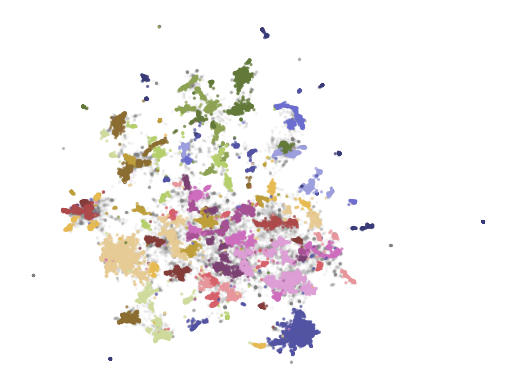

In [9]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
_ = plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

# From Text Clustering to Topic Modeling

## **BERTopic: A Modular Topic Modeling Framework**

 ![https://maartengr.github.io/BERTopic/algorithm/modularity.svg](https://maartengr.github.io/BERTopic/algorithm/modularity.svg)

In [24]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-12-16 14:45:27,336 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-16 14:46:27,030 - BERTopic - Dimensionality - Completed ✓
2025-12-16 14:46:27,032 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-16 14:46:29,779 - BERTopic - Cluster - Completed ✓
2025-12-16 14:46:29,792 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-16 14:46:34,074 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [25]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14210,-1_of_the_and_to,"[of, the, and, to, in, we, language, for, that...",[ GPT-$3$ has attracted lots of attention due...
1,0,2316,0_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...",[ The speech chain mechanism integrates autom...
2,1,2183,1_question_qa_questions_answer,"[question, qa, questions, answer, answering, a...",[ Text-based Question Generation (QG) aims at...
3,2,941,2_translation_nmt_machine_bleu,"[translation, nmt, machine, bleu, neural, engl...","[ Recently, the development of neural machine..."
4,3,880,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Sentence summarization shortens given texts...
...,...,...,...,...,...
150,149,54,149_sentence_embeddings_sts_embedding,"[sentence, embeddings, sts, embedding, similar...",[ Sentence representation at the semantic lev...
151,150,54,150_gans_gan_adversarial_generation,"[gans, gan, adversarial, generation, generativ...",[ Text generation is of particular interest i...
152,151,54,151_coherence_discourse_paragraph_text,"[coherence, discourse, paragraph, text, cohesi...",[ While there has been significant progress t...
153,152,53,152_chatgpt_its_openai_tasks,"[chatgpt, its, openai, tasks, has, ai, capabil...","[ Over the last few years, large language mod..."


Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:

In [26]:
topic_model.get_topic(0)

[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [27]:
topic_model.find_topics("topic modeling")

([24, -1, 38, 32, 84],
 [np.float32(0.9545274),
  np.float32(0.9123676),
  np.float32(0.9080541),
  np.float32(0.9053283),
  np.float32(0.90453553)])

It returns that topic 24 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [28]:
topic_model.get_topic(24)

[('topic', np.float64(0.06811153301756999)),
 ('topics', np.float64(0.035746717561104396)),
 ('lda', np.float64(0.016020062969070364)),
 ('latent', np.float64(0.013574936227317968)),
 ('documents', np.float64(0.013201698266173009)),
 ('document', np.float64(0.012912590658853182)),
 ('modeling', np.float64(0.012084716289729468)),
 ('dirichlet', np.float64(0.01010281253111858)),
 ('word', np.float64(0.008653858081603273)),
 ('allocation', np.float64(0.007950503995528465))]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 24:

In [29]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

24

It is! We expected it might be because there are non-LDA specific words in the topic describtion such as "clustering" and "topic".

### **Visualizations**

In [30]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [31]:
# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model.
To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [32]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [33]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired
KeyBERT is a keyword extraction method that complements BERTopic by providing interpretable topic representations.

It works by leveraging the same document embeddings used in BERTopic:

1. For each topic (cluster of documents), compute the centroid embedding.
2. Rank all words or candidate keywords by their cosine similarity to the topic centroid.
3. Select the top N words (default N=10) with the highest similarity as representative keywords.

Intuition:
- Words that are semantically close to the topic centroid are good representatives of that topic.
- KeyBERT thus provides human-readable keywords without retraining any model.

In [34]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,phonetic | encoder | transcription | speech | ...
1,1,question | qa | questions | answer | answering,answering | comprehension | questions | questi...
2,2,translation | nmt | machine | bleu | neural,translation | translate | translations | trans...
3,3,summarization | summaries | summary | abstract...,summarization | summarizers | summaries | summ...
4,4,hate | offensive | speech | detection | toxic,hate | hateful | language | offensive | languages


### Maximal Marginal Relevance
Maximal Marginal Relevance (MMR) is an optional keyword refinement method used in BERTopic to improve the diversity of topic keywords.

It works as follows:
1. Start with a set of candidate keywords. The first keyword is often chosen as the one with highest cosine similarity to the topic centroid (as in KeyBERT), but other selection criteria can be used as well.
2. Iteratively select keywords that maximize relevance to the topic while minimizing similarity to already selected keywords.
3. Continue until the top N keywords (default N=10) are selected.

Intuition:
- Ensures that the final keywords are both relevant and diverse.
- Prevents multiple keywords that are semantically very similar from dominating the topic representation.

In [35]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,speech | asr | error | automatic | model
1,1,question | qa | questions | answer | answering,questions | retrieval | comprehension | hop | to
2,2,translation | nmt | machine | bleu | neural,translation | nmt | bleu | neural | parallel
3,3,summarization | summaries | summary | abstract...,summarization | document | extractive | rouge ...
4,4,hate | offensive | speech | detection | toxic,offensive | toxic | social | hateful | platforms


## Text Generation



### Flan-T5

In [22]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
100%|██████████| 155/155 [01:09<00:00,  2.24it/s]


,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,Speech-to-speech synthesis | | | |
1,1,question | qa | questions | answer | answering,Question answering systems | | | |
2,2,translation | nmt | machine | bleu | neural,Science/Tech | | | |
3,3,summarization | summaries | summary | abstract...,Document summarization | | | |
4,4,hate | offensive | speech | detection | toxic,Science/Tech | | | |


### OpenAI

In [36]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [37]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key=OPENAI_API_KEY)
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

100%|██████████| 155/155 [03:10<00:00,  1.23s/it]


,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,Multimodal Speech Recognition Systems
1,1,question | qa | questions | answer | answering,Advancements in Question Answering Systems and...
2,2,translation | nmt | machine | bleu | neural,Advances in Neural Machine Translation: Levera...
3,3,summarization | summaries | summary | abstract...,Document Summarization Techniques
4,4,hate | offensive | speech | detection | toxic,Multilingual Hate Speech Detection and Classif...


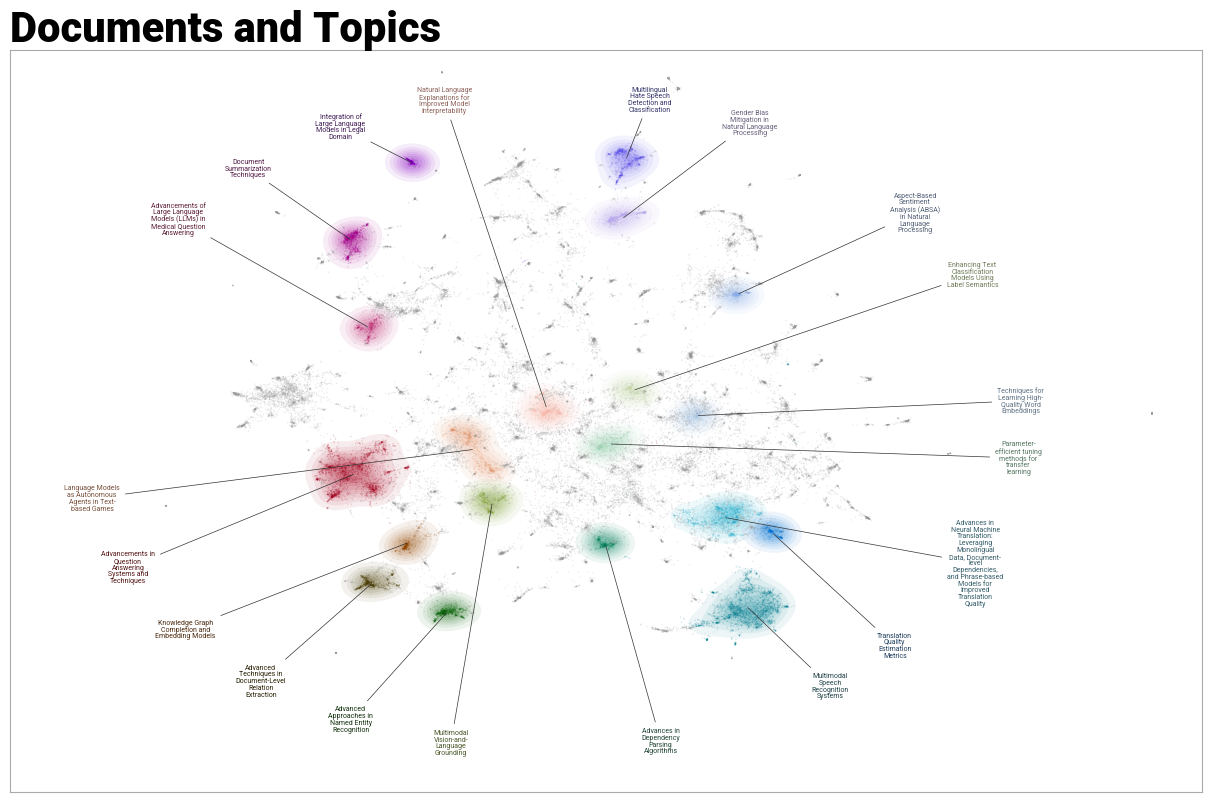

In [38]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200
)
# plt.savefig("datamapplot.png", dpi=300)